In [1]:
#%matplotlib inline 
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import math
from datetime import datetime as dt
from datetime import timedelta

from sklearn.svm import SVR 
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM, Conv2D, MaxPooling2D, Activation, Dropout, Dropout, Dense, Flatten
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#  Load data


In [2]:
data = pd.read_csv('data_final.csv')
data = data.drop(data.columns[0], axis =1)
data['timestamp'] = data['timestamp'].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S.%f')

In [3]:
weather = pd.read_csv('weather_data.csv')
weather = weather.drop(weather.columns[0], axis =1)
weather['timestamp'] = weather['timestamp'].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S.%f')

In [4]:
weather

,timestamp,temp,dew,humidity,precip,windspeed,cloudcover,visibility,solarenergy
0,2016-05-02 15:00:00,15.3,0.4,36.28,0.0,9.2,0.1,29.4,2.100000
1,2016-05-02 16:00:00,14.8,-0.1,36.07,0.0,10.3,0.1,28.2,1.800000
2,2016-05-02 17:00:00,15.2,-0.3,34.75,0.0,8.8,0.0,29.7,1.500000
3,2016-05-02 18:00:00,15.7,-3.1,27.35,0.0,12.2,0.0,32.9,1.100000
4,2016-05-02 19:00:00,15.3,-2.1,30.12,0.0,10.4,0.0,34.7,0.600000
...,...,...,...,...,...,...,...,...,...
39437,2020-10-31 20:00:00,7.9,7.0,93.86,0.0,10.0,90.3,15.4,0.735487
39438,2020-10-31 21:00:00,8.2,7.3,94.13,0.0,6.9,91.9,15.2,0.735487
39439,2020-10-31 22:00:00,8.6,7.5,92.64,0.0,7.4,91.9,17.4,0.735487
39440,2020-10-31 23:00:00,8.9,6.9,87.30,0.0,7.9,91.9,26.8,0.735487


In [5]:
data

,timestamp,A.I. Virtasen aukio,"Aalto-yliopisto (M), Korkeakouluaukio","Aalto-yliopisto (M), Tietotie",Abraham Wetterin tie,Agnetankuja,Agronominkatu,Ahertajantie,Alakiventie,Albertinkatu,...,Viikin normaalikoulu,Viikin tiedepuisto,Viiskulma,Vilhonvuorenkatu,Voikukantie,Von Daehnin katu,Westendinasema,Westendintie,Yhdyskunnankuja,Ympyrätalo
0,2016-05-02 15:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1,2016-05-02 16:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
2,2016-05-02 17:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,2016-05-02 18:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10
4,2016-05-02 19:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39437,2020-10-31 20:00:00,0,2,0,0,0,0,0,0,1,...,0,1,4,0,0,0,1,0,0,2
39438,2020-10-31 21:00:00,0,1,1,0,1,0,0,0,1,...,0,0,0,3,0,0,0,0,0,2
39439,2020-10-31 22:00:00,0,3,2,0,0,1,0,0,0,...,0,1,1,1,0,0,0,0,0,3
39440,2020-10-31 23:00:00,0,2,1,0,2,0,0,0,1,...,0,0,0,1,0,0,2,0,0,0


Model Building LSTM

In [6]:
all_stations_demand = data.set_index('timestamp')
all_stations_demand

,A.I. Virtasen aukio,"Aalto-yliopisto (M), Korkeakouluaukio","Aalto-yliopisto (M), Tietotie",Abraham Wetterin tie,Agnetankuja,Agronominkatu,Ahertajantie,Alakiventie,Albertinkatu,Annankatu,...,Viikin normaalikoulu,Viikin tiedepuisto,Viiskulma,Vilhonvuorenkatu,Voikukantie,Von Daehnin katu,Westendinasema,Westendintie,Yhdyskunnankuja,Ympyrätalo
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-05-02 15:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2016-05-02 16:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
2016-05-02 17:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
2016-05-02 18:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10
2016-05-02 19:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-31 20:00:00,0,2,0,0,0,0,0,0,1,0,...,0,1,4,0,0,0,1,0,0,2
2020-10-31 21:00:00,0,1,1,0,1,0,0,0,1,0,...,0,0,0,3,0,0,0,0,0,2
2020-10-31 22:00:00,0,3,2,0,0,1,0,0,0,5,...,0,1,1,1,0,0,0,0,0,3


In [7]:
all_stations_demand.columns

Index(['A.I. Virtasen aukio', 'Aalto-yliopisto (M), Korkeakouluaukio',
       'Aalto-yliopisto (M), Tietotie', 'Abraham Wetterin tie', 'Agnetankuja',
       'Agronominkatu', 'Ahertajantie', 'Alakiventie', 'Albertinkatu',
       'Annankatu',
       ...
       'Viikin normaalikoulu', 'Viikin tiedepuisto', 'Viiskulma',
       'Vilhonvuorenkatu', 'Voikukantie', 'Von Daehnin katu', 'Westendinasema',
       'Westendintie', 'Yhdyskunnankuja', 'Ympyrätalo'],
      dtype='object', length=347)

In [8]:
# take sample data to test model
sample_demand = all_stations_demand.iloc[25000:,:20]
sample_weather = weather.iloc[25000:,:]

In [9]:
# create future forecast time
def create_dates(start, hours):
    
    start = pd.to_datetime(start,format='%Y-%m-%d %H:%M:%S.%f')
    time_array = []
    time = start
    for i in range(hours):
        time_array.append(time)
        time = time + timedelta(hours=1)
    forecast_time = pd.DataFrame(index=time_array)
    return forecast_time

# get values, station name and drop null values
def get_value_name(all_station_temp,i):
    station_value = all_station_temp[[all_station_temp.columns[i]]]
    station_name = all_station_temp.columns[i]
    return station_value, station_name

# train-test split for a user input ratio - dataframe
def train_test_split(input_data, name, ratio):
    nrow = len(input_data)
    #name = str(name)[1:-2]
    print(name+' total samples: ',nrow)
    split_row = int((nrow)*ratio)
    print('Training samples: ',split_row)
    print('Testing samples: ',nrow-split_row)
    train = input_data.iloc[:split_row]
    test = input_data.iloc[split_row:]
    return train, test, split_row

# data transformation  --> test 2 senerios: with and without transformation
def data_transformation(train_tract1,test_tract1):
    scaler = MinMaxScaler()
    train_tract1_scaled = scaler.fit_transform(train_tract1)
    test_tract1_scaled = scaler.fit_transform(test_tract1)          
    train_tract1_scaled_df = pd.DataFrame(train_tract1_scaled, index = train_tract1.index, columns=[train_tract1.columns[0]])
    test_tract1_scaled_df = pd.DataFrame(test_tract1_scaled,
                                         index = test_tract1.index, columns=[test_tract1.columns[0]])
    return train_tract1_scaled_df, test_tract1_scaled_df, scaler

# feature builder - This section creates feature set with lag number of predictors--Creating features using lagged data
def timeseries_feature_builder(df, lag):
    df_copy = df.copy()
    for i in range(1,lag):
        df_copy['lag'+str(i)] = df.shift(i) 
    return df_copy



# preprocessing -- drop null values and make arrays 
def make_arrays(train_tract1,test_tract1):
    X_train_tract1_array = train_tract1.dropna().drop(train_tract1.columns[0], axis=1).values
    y_train_tract1_array = train_tract1.dropna()[train_tract1.columns[0]].values
    X_test_tract1_array = test_tract1.dropna().drop(test_tract1.columns[0], axis=1).values
    y_test_tract1_array = test_tract1.dropna()[test_tract1.columns[0]].values    
    return X_train_tract1_array, y_train_tract1_array, X_test_tract1_array, y_test_tract1_array

# Define LSTM model
def lstm_model(units, trainX, testX, y_train_tract1_array, y_test_tract1_array):
    model = Sequential()
    model.add(LSTM(units,return_sequences=True, input_shape=(trainX.shape[1],trainX.shape[2]),kernel_initializer='lecun_uniform'))
    model.add(Dropout(0.2))    
    model.add(LSTM(units, return_sequences=True))
    model.add(Dropout(0.2))    
    model.add(LSTM(units))
    model.add(Dropout(0.2))
    model.add(Dense(1))        
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    
    model.fit(trainX, y_train_tract1_array, batch_size=120, epochs=100, validation_data=(testX, y_test_tract1_array), verbose=0)
    return model

# validation result 
def valid_result(model, testX, y_test_tract1_array, scaler, station_value, split_row, lag):    
    testPredict = model.predict(testX)
    rSquare_test = r2_score(y_test_tract1_array, testPredict)
    print('Test R-squared is: %f'%rSquare_test)    
    testPredict = scaler.inverse_transform(testPredict)        
    new_test_tract1 = station_value.iloc[split_row:]       
    test_tract1_pred = new_test_tract1.iloc[lag:].copy()
    test_tract1_pred['Forecast'] = testPredict
    return test_tract1_pred

def forecast(model, testX, test_tract1, lag, scaler, days):
    seven_days = []
    new0 = testX[-1]        
    last = test_tract1.iloc[-1]
    new_predict = last[0]        
    new_array = np.insert(new0, 0, new_predict)        
    new_array = np.delete(new_array, -1)
    new_array_reshape = np.reshape(new_array, (-1,1,lag))       
    new_predict = model.predict(new_array_reshape)
    temp_predict = scaler.inverse_transform(new_predict) 
    seven_days.append(temp_predict[0][0].round(2))
    
    for i in range(1,days):
        new_array = np.insert(new_array, 0, new_predict)             
        new_array = np.delete(new_array, -1)
        new_array_reshape = np.reshape(new_array, (-1,1,lag))            
        new_predict = model.predict(new_array_reshape)
        temp_predict = scaler.inverse_transform(new_predict) 
        seven_days.append(temp_predict[0][0].round(2))
    return seven_days
    


In [11]:
## multi step future forecast for next days number of days. 
# actually days is hours
def england_temp_lstm(all_station_temp, lag, days):    

    seven_day_forecast_lstm = create_dates('2020-11-01 00:00:00',days) 

    for i in range(len(all_station_temp.columns)):
        
        # preprocessing
        station_value, station_name = get_value_name(all_station_temp,i)        
        train_tract1, test_tract1, split_row = train_test_split(station_value, station_name, 0.90)        
        train_tract1_scaled_df, test_tract1_scaled_df, scaler = data_transformation(train_tract1,test_tract1) 
        train_tract1 = timeseries_feature_builder(train_tract1_scaled_df, lag+1) 
        test_tract1 = timeseries_feature_builder(test_tract1_scaled_df, lag+1)               
        X_train_tract1_array, y_train_tract1_array, X_test_tract1_array, y_test_tract1_array = make_arrays(train_tract1, 
                                                                                                            test_tract1)        
        trainX = np.reshape(X_train_tract1_array, (X_train_tract1_array.shape[0],1,X_train_tract1_array.shape[1]))
        testX = np.reshape(X_test_tract1_array, (X_test_tract1_array.shape[0],1,X_test_tract1_array.shape[1]))                
        
        # LSTM modelling & forecast
        model = lstm_model(30, trainX, testX, y_train_tract1_array, y_test_tract1_array)             
        test_tract1_pred = valid_result(model, testX, y_test_tract1_array, scaler, station_value, split_row, lag)        
        seven_days = forecast(model, testX, test_tract1, lag, scaler, days)       
        seven_day_forecast_lstm[station_name] = np.array(seven_days)       
        
        # plot result
        plt.figure(figsize=(20,5))
        plt.plot(test_tract1_pred)        
        plt.plot(seven_day_forecast_lstm[station_name], color='red', label='forecast')         
        plt.ylabel('Number of Pickup')
        plt.legend(loc='upper right')
        plt.title(station_name + '- Demand Forecast')
        plt.show()        
        
    return(seven_day_forecast_lstm) 

In [12]:
%%time
# Fitting and forecast using LSTM  -- output of train loss and valid loss is turned off
lstm_prediction = england_temp_lstm(sample_demand,120,31)

Output hidden; open in https://colab.research.google.com to view.

Support Vector Machine

In [13]:
# fitting & Validating using SVR
def fit_svr(X_train_tract1_array, y_train_tract1_array, X_test_tract1_array, y_test_tract1_array):
    model_svr = SVR(kernel='rbf', gamma='auto', tol=0.001, C=10.0, epsilon=0.001)
    model_svr.fit(X_train_tract1_array,y_train_tract1_array)
    y_pred_train_tract1 = model_svr.predict(X_train_tract1_array)
    y_pred_test_tract1 = model_svr.predict(X_test_tract1_array)        
    print('r-square_SVR_Test: ', round(model_svr.score(X_test_tract1_array,y_test_tract1_array),2))
    return model_svr, y_pred_test_tract1   

# validation result  
def valid_result_svr(scaler, y_pred_test_tract1, station_value, split_row, lag):
    new_test_tract1 = station_value.iloc[split_row:]
    test_tract1_pred = new_test_tract1.iloc[lag:].copy()
    y_pred_test_tract1_transformed = scaler.inverse_transform([y_pred_test_tract1])
    y_pred_test_tract1_transformed_reshaped = np.reshape(y_pred_test_tract1_transformed,(y_pred_test_tract1_transformed.shape[1],-1))
    test_tract1_pred['Forecast'] = np.array(y_pred_test_tract1_transformed_reshaped)
    return test_tract1_pred

# multi-step future forecast
def forecast_svr(X_test_tract1_array, days ,model_svr, lag, scaler):
    last_test_sample = X_test_tract1_array[-1]        
    X_last_test_sample = np.reshape(last_test_sample,(-1,X_test_tract1_array.shape[1]))        
    y_pred_last_sample = model_svr.predict(X_last_test_sample)                
    new_array = X_last_test_sample
    new_predict = y_pred_last_sample
    new_array = X_last_test_sample
    new_predict = y_pred_last_sample

    seven_days_svr=[]
    for i in range(0,days):               
            new_array = np.insert(new_array, 0, new_predict)                
            new_array = np.delete(new_array, -1)
            new_array_reshape = np.reshape(new_array, (-1,lag))                
            new_predict = model_svr.predict(new_array_reshape)
            temp_predict = scaler.inverse_transform([new_predict])
            seven_days_svr.append(temp_predict[0][0].round(2))
            
    return seven_days_svr 

In [14]:
def england_temp_svr(all_station_temp, lag, days):     
    
    seven_day_forecast_svr = create_dates('2019-09-30',days)
    
    for i in range(len(all_station_temp.columns)):
        
        # preprocessing
        station_value, station_name = get_value_name(all_station_temp,i)       
        train_tract1, test_tract1, split_row = train_test_split(station_value, station_name, 0.80)              
        train_tract1_scaled_df, test_tract1_scaled_df, scaler = data_transformation(train_tract1,test_tract1)        
        train_tract1 = timeseries_feature_builder(train_tract1_scaled_df,lag+1)
        test_tract1 = timeseries_feature_builder(test_tract1_scaled_df, lag+1)        
        X_train_tract1_array, y_train_tract1_array, X_test_tract1_array, y_test_tract1_array = make_arrays(train_tract1,
                                                                                                           test_tract1)

        # SVR modeling
        model_svr, y_pred_test_tract1 = fit_svr(X_train_tract1_array, y_train_tract1_array,
                                                X_test_tract1_array, y_test_tract1_array)                       
        test_tract1_pred = valid_result_svr(scaler, y_pred_test_tract1, station_value, split_row, lag)        
        seven_days_svr = forecast_svr(X_test_tract1_array, days, model_svr, lag, scaler)            
        seven_day_forecast_svr[station_name] = np.array(seven_days_svr)        
        
        # plot result
        plt.figure(figsize=(20,5))
        plt.plot(test_tract1_pred)
        plt.plot(seven_day_forecast_svr[station_name], color='red', label='forecast') 
        plt.ylabel('Temperature(°C)')
        plt.legend(loc='upper right')
        plt.title(station_name + '- October 2019 Temperature Forecast')
        plt.show()    
        
    return(seven_day_forecast_svr)

A.I. Virtasen aukio total samples:  14442
Training samples:  11553
Testing samples:  2889


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


r-square_SVR_Test:  0.33


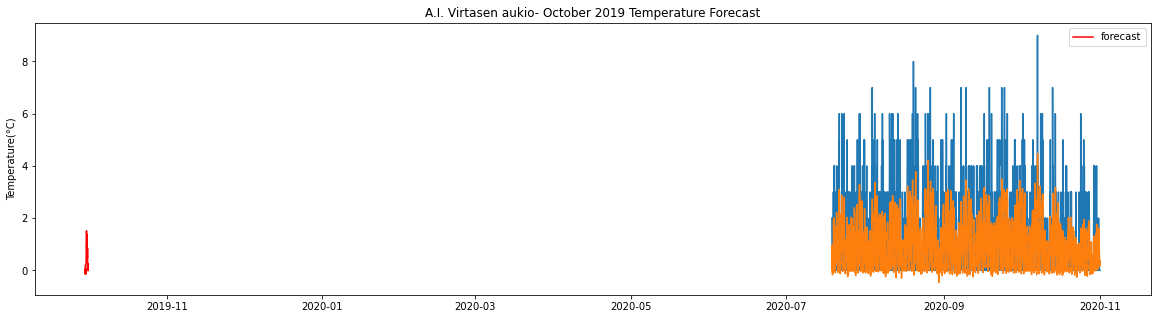

Aalto-yliopisto (M), Korkeakouluaukio total samples:  14442
Training samples:  11553
Testing samples:  2889


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


r-square_SVR_Test:  0.75


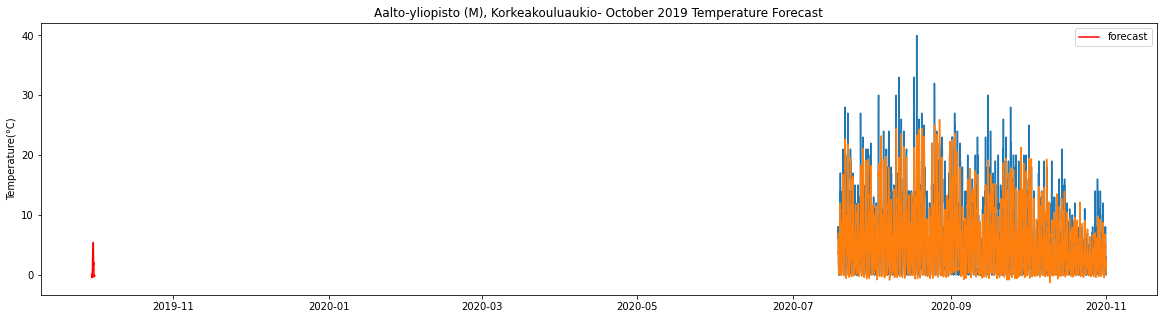

Aalto-yliopisto (M), Tietotie total samples:  14442
Training samples:  11553
Testing samples:  2889


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


r-square_SVR_Test:  0.42


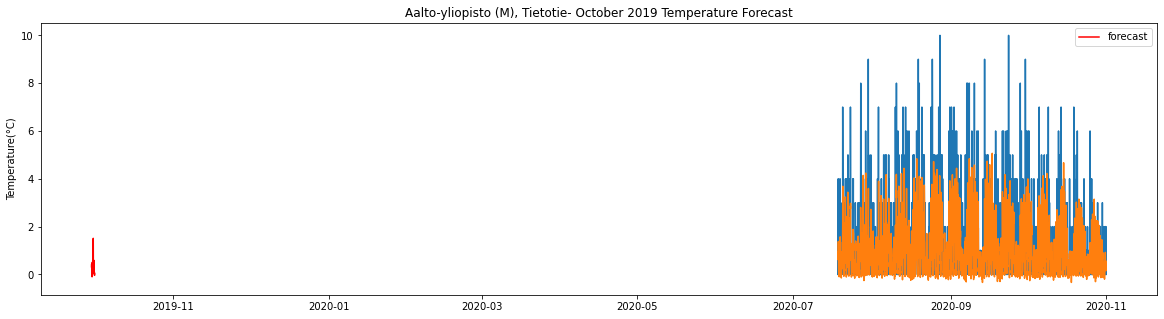

Abraham Wetterin tie total samples:  14442
Training samples:  11553
Testing samples:  2889


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


r-square_SVR_Test:  0.22


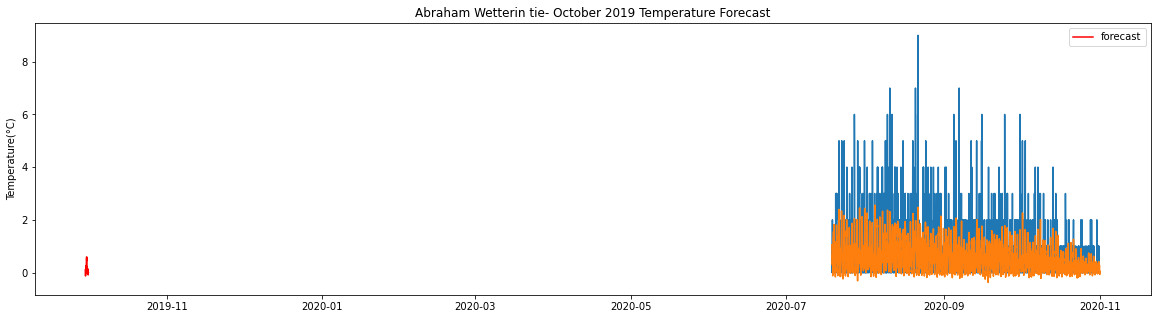

Agnetankuja total samples:  14442
Training samples:  11553
Testing samples:  2889


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


r-square_SVR_Test:  0.34


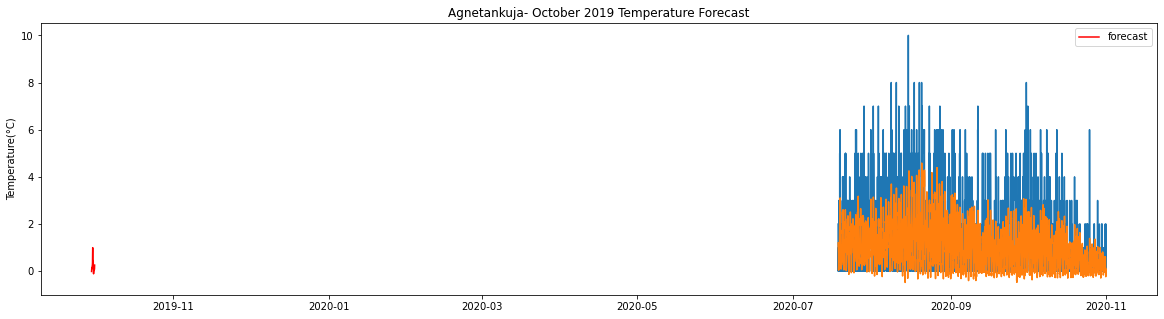

Agronominkatu total samples:  14442
Training samples:  11553
Testing samples:  2889


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


r-square_SVR_Test:  0.19


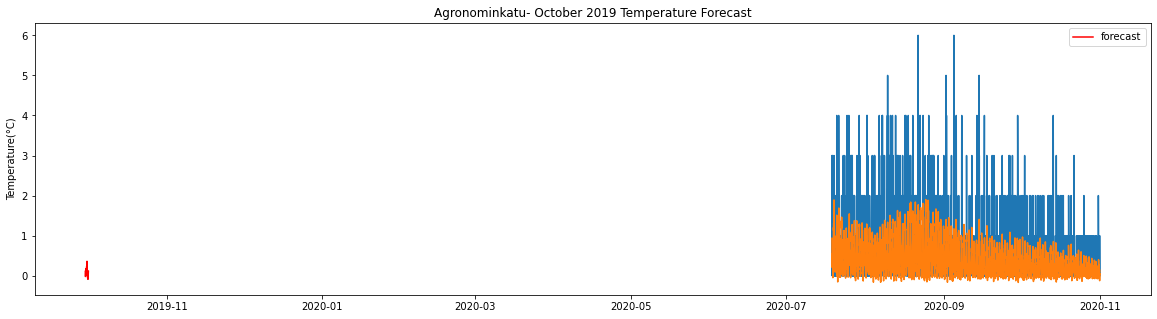

Ahertajantie total samples:  14442
Training samples:  11553
Testing samples:  2889


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


r-square_SVR_Test:  0.28


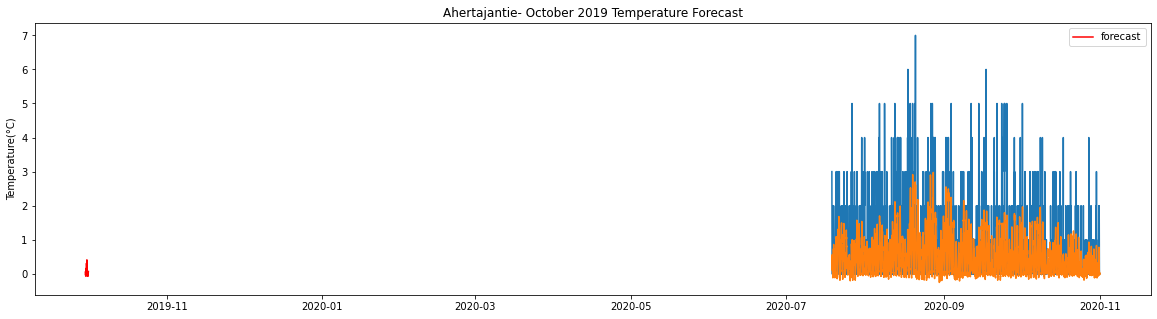

Alakiventie total samples:  14442
Training samples:  11553
Testing samples:  2889


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


r-square_SVR_Test:  -0.11


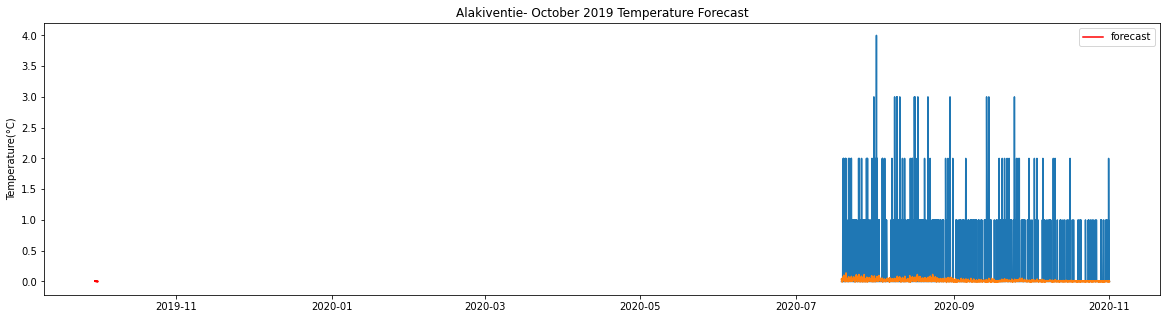

Albertinkatu total samples:  14442
Training samples:  11553
Testing samples:  2889


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


r-square_SVR_Test:  0.53


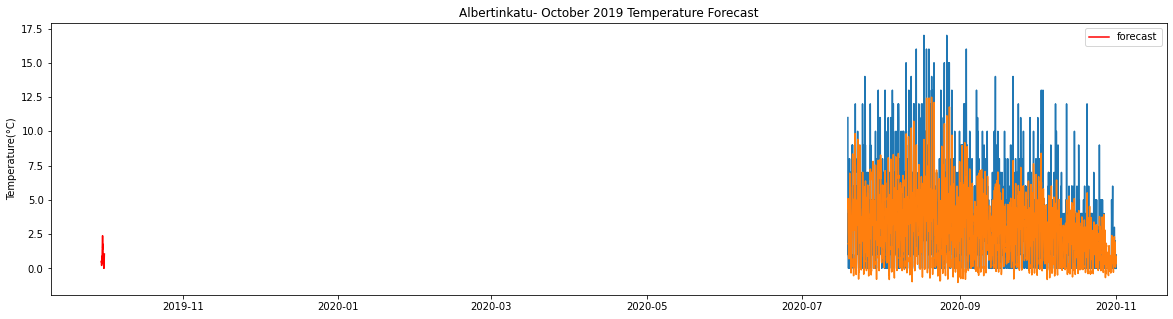

Annankatu total samples:  14442
Training samples:  11553
Testing samples:  2889


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


r-square_SVR_Test:  0.5


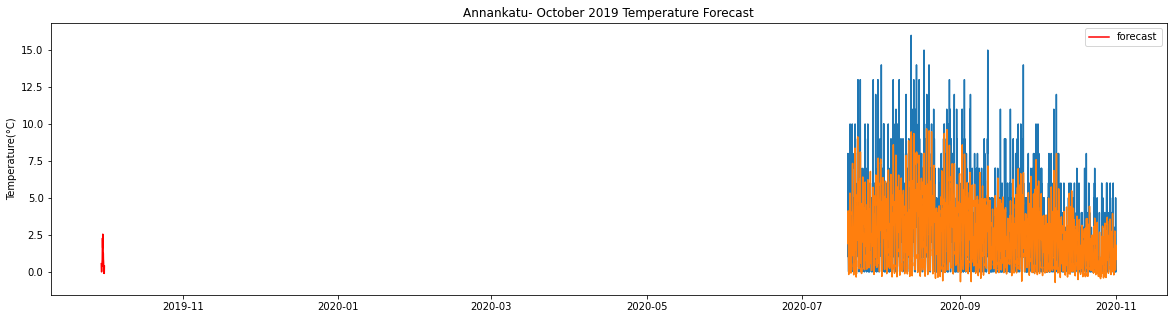

Apollonkatu total samples:  14442
Training samples:  11553
Testing samples:  2889


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


r-square_SVR_Test:  0.62


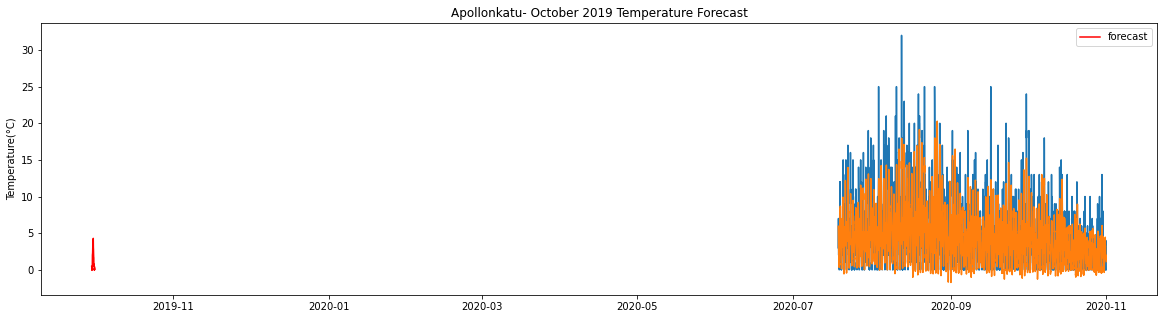

Arabian kauppakeskus total samples:  14442
Training samples:  11553
Testing samples:  2889


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


r-square_SVR_Test:  0.7


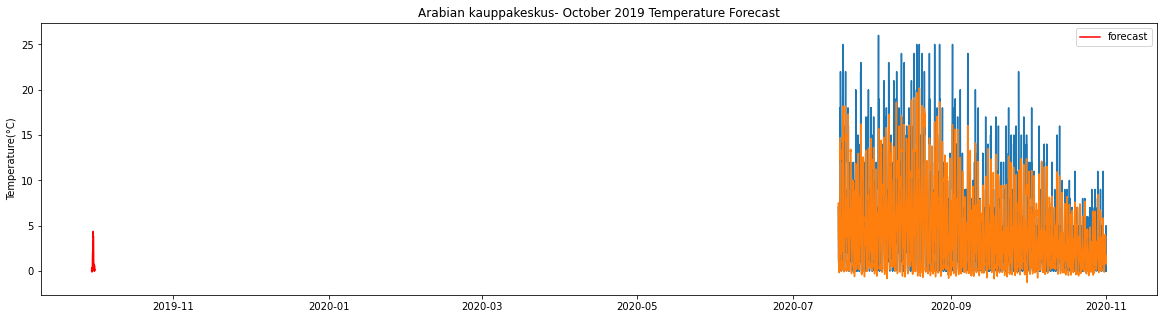

Arabiankatu total samples:  14442
Training samples:  11553
Testing samples:  2889


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


r-square_SVR_Test:  0.51


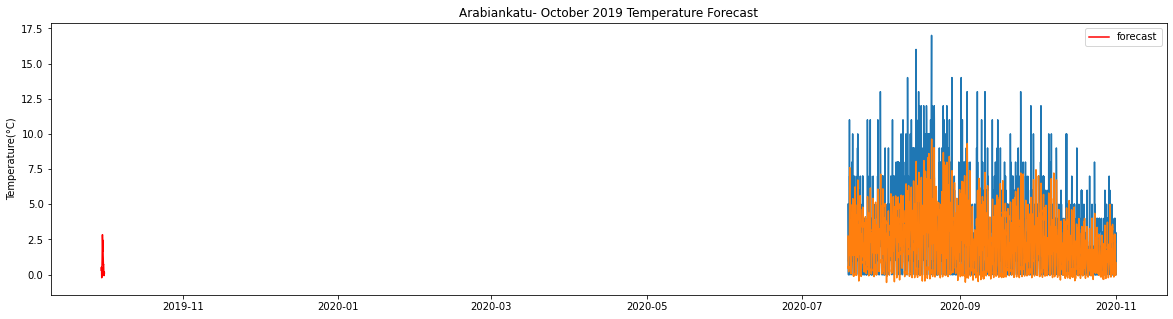

Arielinkatu total samples:  14442
Training samples:  11553
Testing samples:  2889


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


r-square_SVR_Test:  0.34


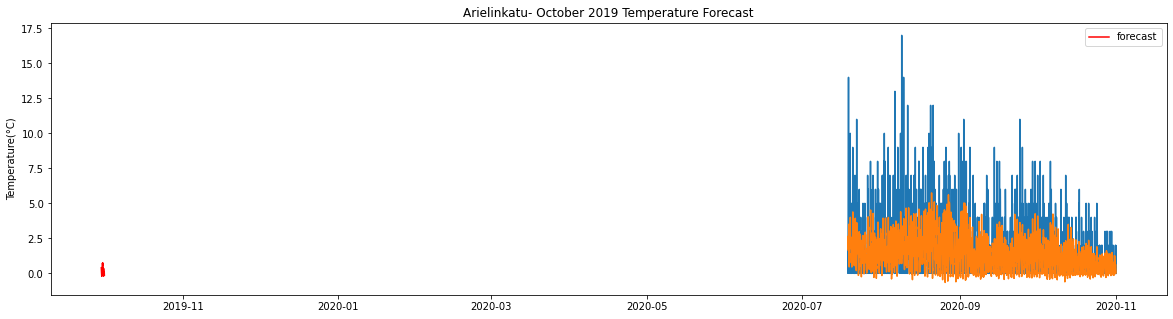

Asentajanpuisto total samples:  14442
Training samples:  11553
Testing samples:  2889


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


r-square_SVR_Test:  0.24


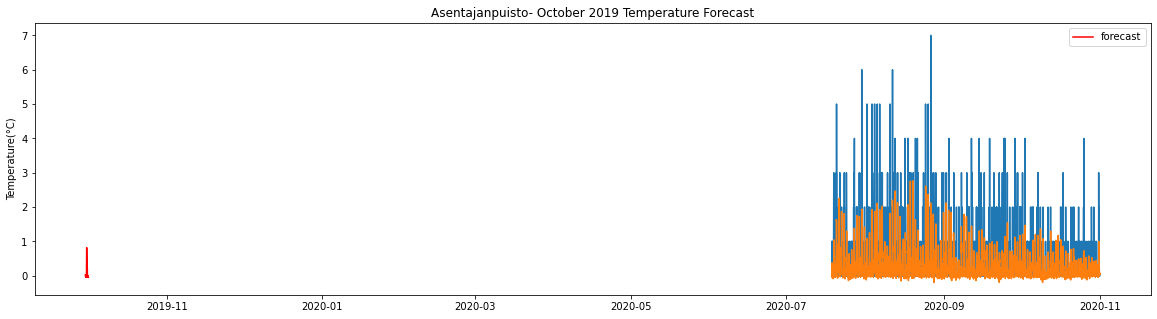

Aulangontie total samples:  14442
Training samples:  11553
Testing samples:  2889


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


r-square_SVR_Test:  -0.12


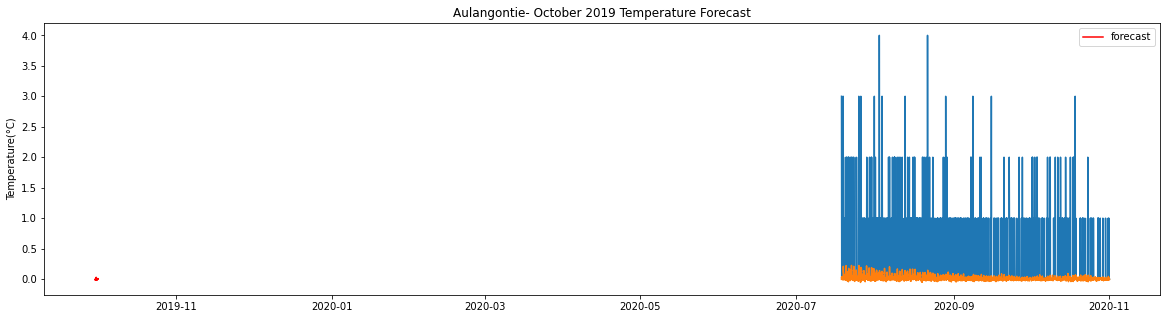

Auringonkatu total samples:  14442
Training samples:  11553
Testing samples:  2889


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


r-square_SVR_Test:  0.07


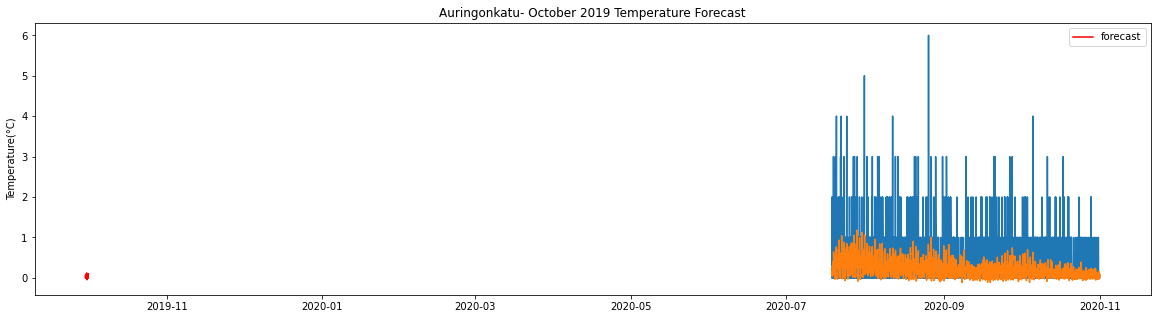

Avaruuskatu total samples:  14442
Training samples:  11553
Testing samples:  2889


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


r-square_SVR_Test:  -0.06


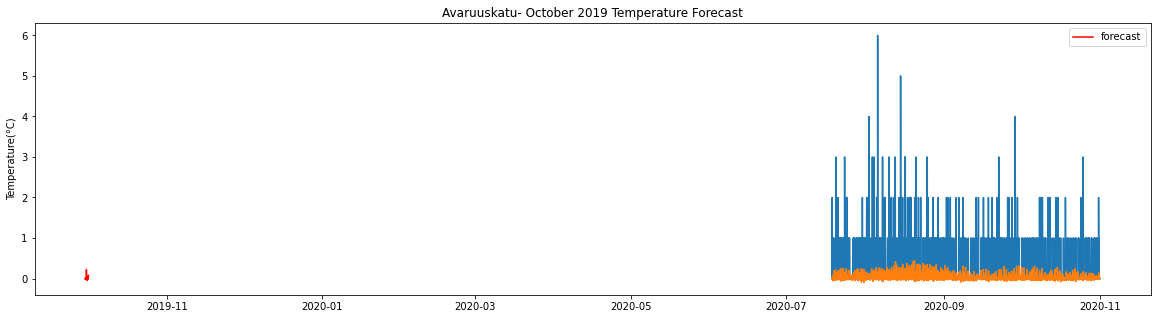

Baana total samples:  14442
Training samples:  11553
Testing samples:  2889


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


r-square_SVR_Test:  0.61


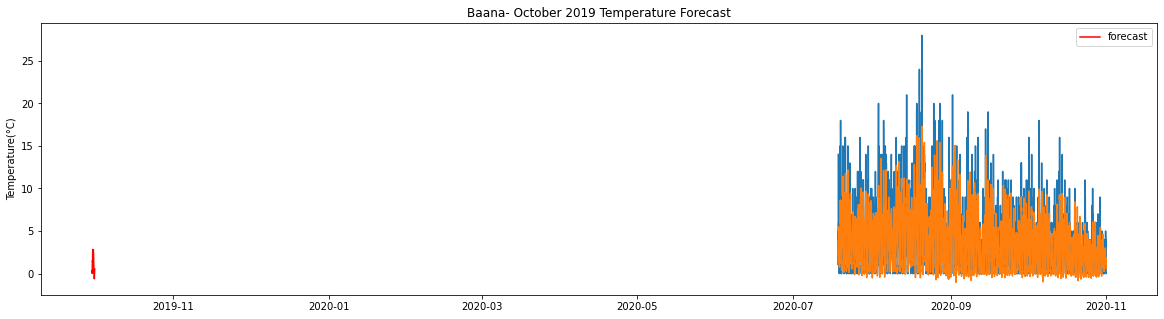

Betonimies total samples:  14442
Training samples:  11553
Testing samples:  2889


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


r-square_SVR_Test:  0.23


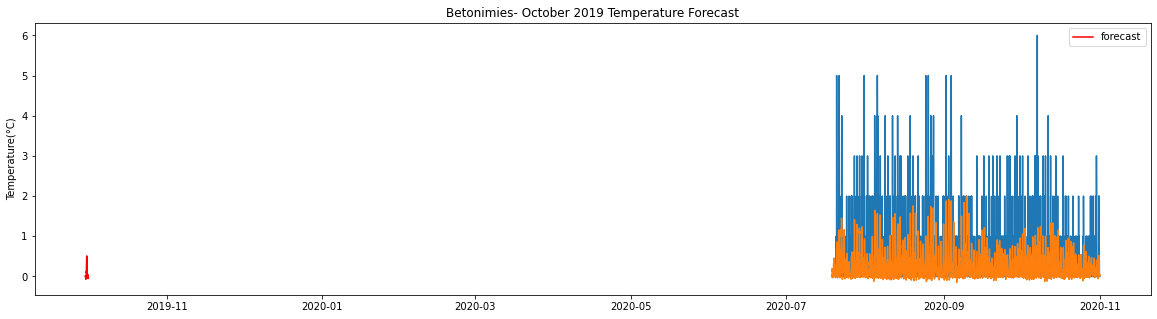

CPU times: user 29min 36s, sys: 1.53 s, total: 29min 38s
Wall time: 29min 37s


In [15]:
%%time
# Fitting and forecast using SVM
svr_prediction = england_temp_svr(sample_demand, 365, 30)